In [ ]:
!pip install split_folders

import os
import matplotlib.pyplot as plt
import zipfile
import splitfolders
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import Callback

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!wget "https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip"
!wget "https://raw.githubusercontent.com/EtheriousKelv/Pyground/main/Helper/modelPlot.py"

In [3]:
local_zip = "/content/rockpaperscissors.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [4]:
main_directory = "/content/rockpaperscissors"

splitfolders.ratio('/content/rockpaperscissors/rps-cv-images', 
                   output="/content/data", 
                   seed=1337, 
                   ratio=(.6, .4)
                   )

Copying files: 2188 files [00:00, 3027.07 files/s]


In [5]:
train_dir = "/content/data/train"
valid_dir = "/content/data/val"

In [6]:
train_image = 0
valid_image = 0

for dir in os.listdir(train_dir):
  train_image += len(os.listdir(os.path.join(train_dir, dir)))

for dir in os.listdir(valid_dir):
  valid_image += len(os.listdir(os.path.join(valid_dir, dir)))

print(train_image)
print(valid_image)

1312
876


In [7]:
train_ds = image_dataset_from_directory(
    directory = "/content/data/train",
    batch_size = 32,
    label_mode = 'int'
)

valid_ds = image_dataset_from_directory(
    directory = "/content/data/val",
    batch_size = 32,
    label_mode = 'int'
)

Found 1312 files belonging to 3 classes.
Found 876 files belonging to 3 classes.


In [8]:
print(train_ds.class_names)
print(valid_ds.class_names)

['paper', 'rock', 'scissors']
['paper', 'rock', 'scissors']


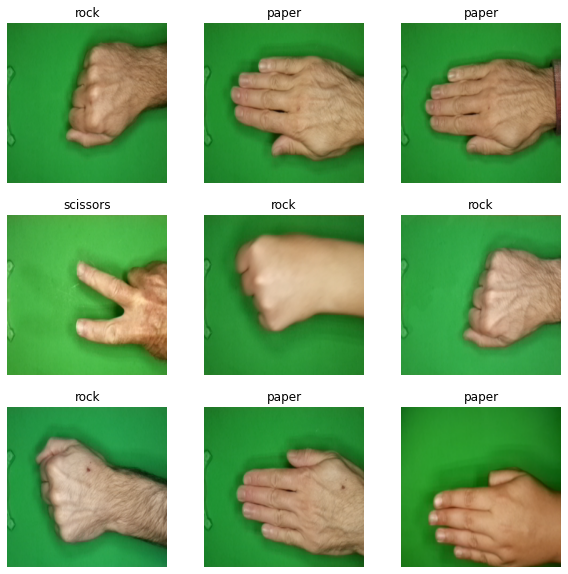

In [9]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.95:
      self.model.stop_training = True

callbacks = myCallback()

In [11]:
IMG_SIZE = 100

resize_and_rescale = Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
], name='data_augmentation')

model = Sequential([
    layers.Conv2D(32, (3,3), activation=tf.nn.relu, input_shape=(100, 100, 3)),
    layers.MaxPool2D(2, 2),
    layers.Conv2D(64, (3,3), activation=tf.nn.relu),
    layers.MaxPool2D(2, 2),
    layers.Conv2D(64, (3,3), activation=tf.nn.relu),
    layers.MaxPool2D(2, 2),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(3, activation='softmax')
], name='convolutional_neural_network')

In [12]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
train_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y)
)

valid_ds = valid_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y)
)

In [14]:
history = model.fit(train_ds, validation_data=valid_ds, epochs=5, callbacks=[callbacks])

Epoch 1/5
41/41 [==============================] - 13s 234ms/step - loss: 0.8869 - accuracy: 0.6113 - val_loss: 0.5425 - val_accuracy: 0.8014
Epoch 2/5
41/41 [==============================] - 10s 214ms/step - loss: 0.4056 - accuracy: 0.8681 - val_loss: 0.3314 - val_accuracy: 0.8721
Epoch 3/5
41/41 [==============================] - 5s 111ms/step - loss: 0.2099 - accuracy: 0.9238 - val_loss: 0.3144 - val_accuracy: 0.8756
Epoch 4/5
41/41 [==============================] - 5s 108ms/step - loss: 0.1345 - accuracy: 0.9512 - val_loss: 0.1367 - val_accuracy: 0.9509


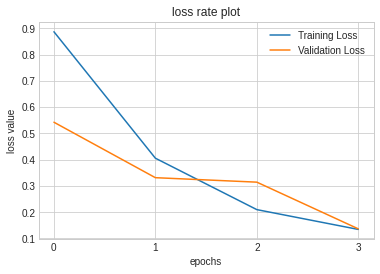

In [15]:
from modelPlot import ModelPlot

model_plot = ModelPlot(history)

model_plot.loss_plot()

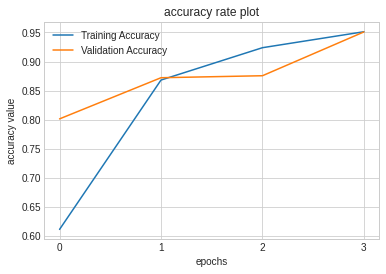

In [16]:
model_plot.accuracy_plot()

In [17]:
model.evaluate(train_ds)

41/41 [==============================] - 3s 61ms/step - loss: 0.1014 - accuracy: 0.9619


[0.10135964304208755, 0.9618902206420898]

In [18]:
model.evaluate(valid_ds)

28/28 [==============================] - 2s 54ms/step - loss: 0.1367 - accuracy: 0.9509


[0.1366800218820572, 0.9509132504463196]

In [19]:
export_dir = '/content/saved_model'

tf.saved_model.save(model, export_dir = export_dir)

In [20]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

tflite_model = converter.convert()